In [1]:
import pandas as pd
import zipfile
import io
import matplotlib.pyplot as plt
import seaborn as sns

# Шляхи до ZIP файлів
train_zip_path = '/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip'
test_zip_path = '/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip'
test_labels_zip_path = '/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip'

# Функція для читання CSV з ZIP файлу
def read_csv_from_zip(zip_path, filename):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        with zip_ref.open(filename) as file:
            return pd.read_csv(file)

# Читання CSV файлів безпосередньо з ZIP
train = read_csv_from_zip(train_zip_path, 'train.csv')
test = read_csv_from_zip(test_zip_path, 'test.csv')
test_labels = read_csv_from_zip(test_labels_zip_path, 'test_labels.csv')


# Об'єднання test та test_labels за колонкою 'id'
test_combined = pd.merge(test, test_labels, on='id')
test_combined = test_combined.loc[test_combined['toxic'] >= 0]
test_combined.reset_index(inplace=True)
test_combined = test_combined.drop(columns=['index'])


# Додавання об'єднаного тестового датасету до тренувального датасету
train_combined = pd.concat([train, test_combined], ignore_index=True)
print(train_combined.shape)
train_combined.head()

(223549, 8)


id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0

In [2]:
# Виведення назв категорій
categories = list(train_combined.columns.values)
categories = categories[2:]
print(categories)

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [3]:
counts = []
for category in categories:
    counts.append((category, train_combined[category].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number of comments'])
df_stats

category  number of comments
0          toxic               21384
1   severe_toxic                1962
2        obscene               12140
3         threat                 689
4         insult               11304
5  identity_hate                2117

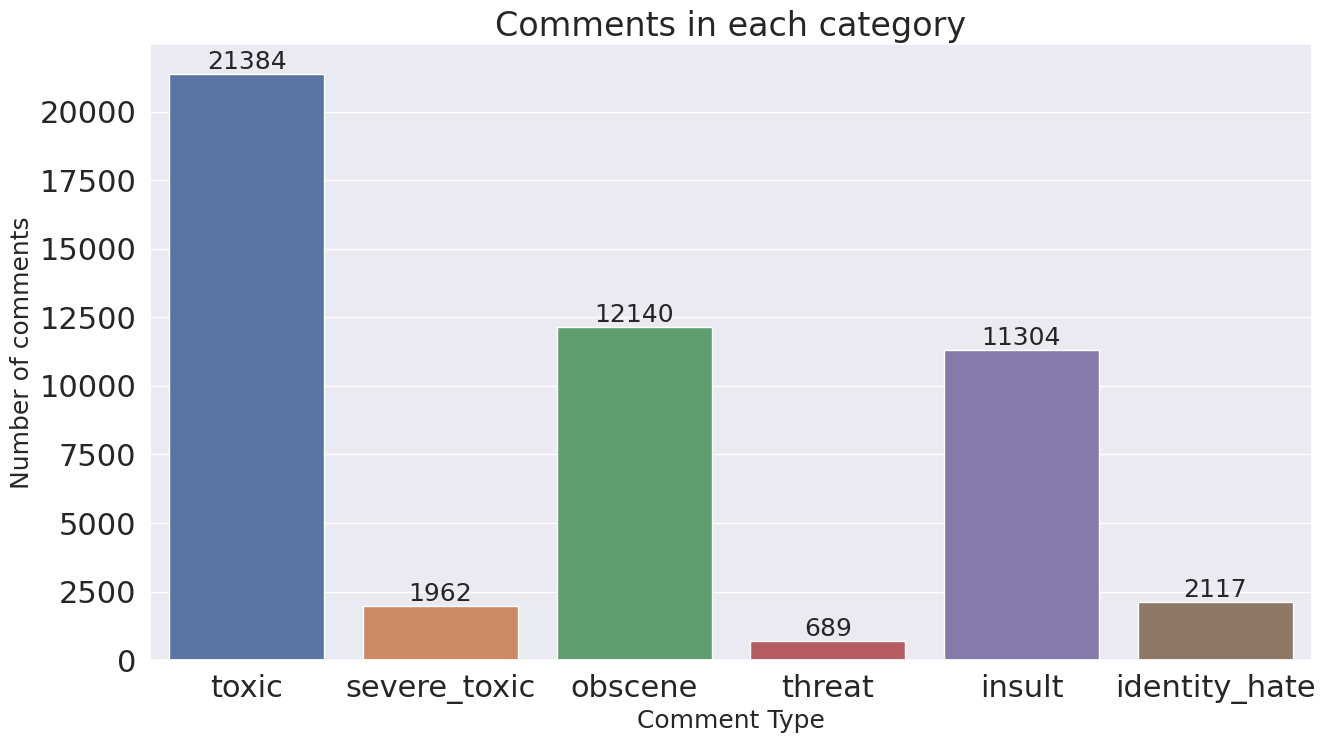

In [4]:
# Ваші категорії
categories = train_combined.columns[2:]

# Підрахунок кількості коментарів у кожній категорії
comments_count = train_combined.iloc[:, 2:].sum().values

# Налаштування шрифту
sns.set(font_scale = 2)
plt.figure(figsize=(15, 8))

# Побудова графіка
ax = sns.barplot(x=categories, y=comments_count)

plt.title("Comments in each category", fontsize=24)
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Comment Type', fontsize=18)

# Додавання текстових міток на графіку
rects = ax.patches
labels = comments_count
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)

plt.show()

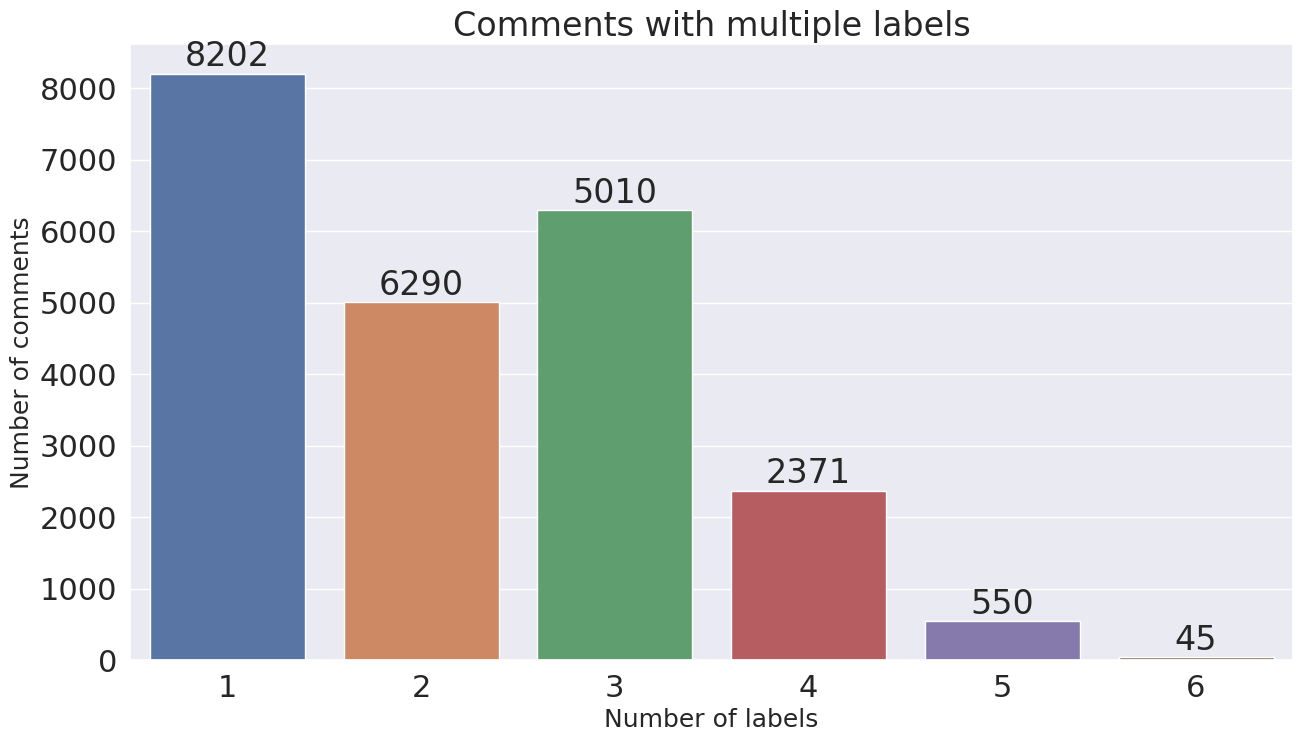

In [11]:
# Підрахунок кількості міток у кожному рядку
rowSums = train_combined.iloc[:,2:].sum(axis=1)

# Підрахунок кількості коментарів з кількома мітками
multiLabel_counts = rowSums.value_counts()

# Відкинемо коментарі без міток
multiLabel_counts = multiLabel_counts.iloc[1:]

sns.set(font_scale=2)
plt.figure(figsize=(15, 8))

# Побудова графіка
ax = sns.barplot(x=multiLabel_counts.index, y=multiLabel_counts.values)

plt.title("Comments with multiple labels")
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)

# Додавання текстових міток на графіку
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

no_negative_comments: 201081
negative_comments: 22468


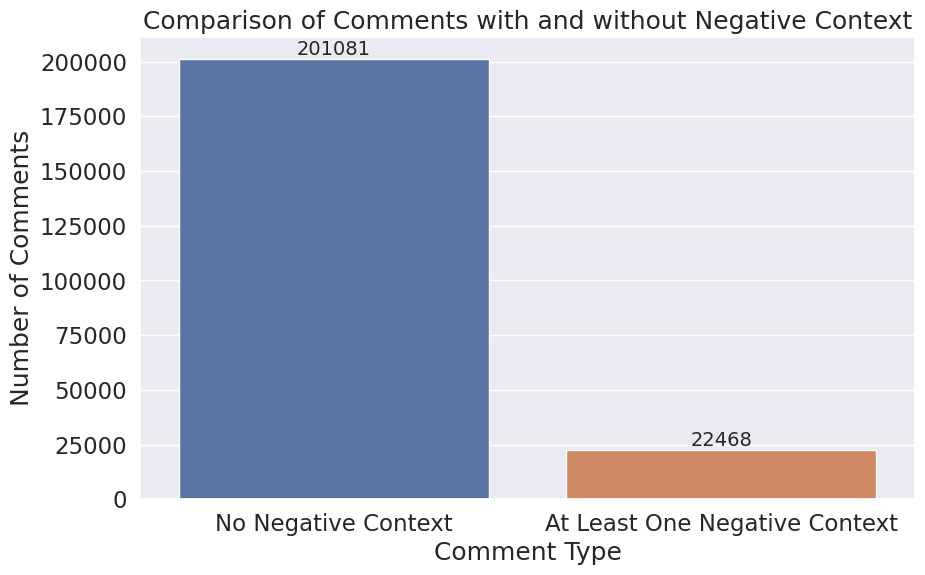

In [13]:
# Виберемо коментарі, які не містять жодного негативного контексту
no_negative_comments = train_combined[
    (train_combined['toxic'] == 0) & 
    (train_combined['severe_toxic'] == 0) & 
    (train_combined['obscene'] == 0) & 
    (train_combined['threat'] == 0) & 
    (train_combined['insult'] == 0) & 
    (train_combined['identity_hate'] == 0)
]

print(f"no_negative_comments: {len(no_negative_comments)}")

negative_comments = train_combined[
    (train_combined['toxic'] == 1) | 
    (train_combined['severe_toxic'] == 1) | 
    (train_combined['obscene'] == 1) | 
    (train_combined['threat'] == 1) | 
    (train_combined['insult'] == 1) | 
    (train_combined['identity_hate'] == 1)
]

print(f"negative_comments: {len(negative_comments)}")

# Підготовка даних для графіка
comment_types = ['No Negative Context', 'At Least One Negative Context']
comment_counts = [len(no_negative_comments), len(negative_comments)]

# Перетворення comment_types у pd.Series
comment_types_series = pd.Series(comment_types)

# Побудова графіка
sns.set(font_scale=1.5)
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=comment_types_series, y=comment_counts)

# Додавання підписів до графіка
plt.title('Comparison of Comments with and without Negative Context')
plt.ylabel('Number of Comments')
plt.xlabel('Comment Type')

# Додавання текстових міток до стовпчиків
for i, count in enumerate(comment_counts):
    ax.text(i, count + 100, str(count), ha='center', va='bottom', fontsize=14)

plt.show()